In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2

import math

In [4]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))
            X = torch.cat((X,X,X),0)

        return X, y

In [5]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## VGG-16 with Feature Act

In [6]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [17]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
        src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_feature * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x

In [20]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, extractor_grad=True, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        vgg_sample = models.vgg16_bn(pretrained=True)
        
        self.features_0 = vgg_sample.features[:7]
        self.features_1 = vgg_sample.features[7:14]
        self.features_2 = vgg_sample.features[14:24]
        self.features_3 = vgg_sample.features[24:44]
        
        
#         if not extractor_grad:
#             for param in self.features_0.parameters():
#                 param.requires_grad = False
#             for param in self.features_1.parameters():
#                 param.requires_grad = False
#             for param in self.features_2.parameters():
#                 param.requires_grad = False
#             for param in self.features_3.parameters():
#                 param.requires_grad = False
        
        self.avgpool = vgg_sample.avgpool
        
        
        for param in self.parameters():
            param.requires_grad = False
        
        self.classifier = vgg_sample.classifier[:6]
        self.classifier.add_module("out", nn.Linear(4096, 7, bias=True))
       
        self.fact0_1 = FeatureAct(64, 128)
        self.fact1_2 = FeatureAct(128, 256)
        self.fact2_3 = FeatureAct(256, 512)

        
#         if not embeddings:
#             self.classifier = nn.Sequential(nn.Flatten(),
#                                             nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
#                                             nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
#                                             nn.Linear(128, 7), nn.BatchNorm1d(7))
#         else:
#             self.classifier = nn.Sequential(nn.Flatten(),
#                                             nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
#                                             nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x0 = self.features_0(x)
        
        x1 = self.features_1(x0)
        xfact0_1 = self.fact0_1(x0, x1)
        
        x2 = self.features_2(xfact0_1)
        xfact1_2 = self.fact1_2(x1, x2)
        
        x3 = self.features_3(xfact1_2)
        xfact2_3 = self.fact2_3(x2, x3)
        
        
        x_emb = self.avgpool(xfact2_3)
        x_emb = nn.Flatten()(x_emb)
        x_out = self.classifier(x_emb)
        
        return x_out, x_emb

In [21]:
device = torch.device('cuda')
model = BaselineFeatureAct(extractor_grad=False).to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [10]:
model_path = './feature_act_vggpretrained_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2957062721252441 cep_loss=2.0694077014923096 triplet_loss=0.135154128074646 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 1.325 | Avg.acc: 0.234


- Avg. val_loss: 1.139 | Avg. val_acc: 0.245


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.1666808128356934 cep_loss=1.8662251234054565 triplet_loss=0.11736416816711426 Batch_id=224 Accuracy=0.16216216216216217: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 1.137 | Avg.acc: 0.254


- Avg. val_loss: 1.123 | Avg. val_acc: 0.246


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.0173734426498413 cep_loss=1.6263726949691772 triplet_loss=0.10387437790632248 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [05:58<00:00,  1.60s/it]

- Avg.loss: 1.115 | Avg.acc: 0.261


- Avg. val_loss: 1.124 | Avg. val_acc: 0.256


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.0423741340637207 cep_loss=1.663703441619873 triplet_loss=0.11038003116846085 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [05:58<00:00,  1.60s/it]

- Avg.loss: 1.058 | Avg.acc: 0.327


- Avg. val_loss: 0.998 | Avg. val_acc: 0.374


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.9841521978378296 cep_loss=1.569207787513733 triplet_loss=0.10656870901584625 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 1.000 | Avg.acc: 0.371



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045 | Avg. val_acc: 0.342
Epoch:  6


Loss=0.9137358665466309 cep_loss=1.4532065391540527 triplet_loss=0.10452975332736969 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [05:58<00:00,  1.60s/it]

- Avg.loss: 0.967 | Avg.acc: 0.393


- Avg. val_loss: 0.913 | Avg. val_acc: 0.424


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.0716381072998047 cep_loss=1.7101664543151855 triplet_loss=0.11384543031454086 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.927 | Avg.acc: 0.420


- Avg. val_loss: 0.909 | Avg. val_acc: 0.436


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.0449891090393066 cep_loss=1.6679778099060059 triplet_loss=0.11050596088171005 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [05:59<00:00,  1.60s/it]

- Avg.loss: 0.942 | Avg.acc: 0.413



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.935 | Avg. val_acc: 0.432
Epoch:  9


Loss=0.9909363985061646 cep_loss=1.58086097240448 triplet_loss=0.10604940354824066 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.920 | Avg.acc: 0.425


- Avg. val_loss: 0.877 | Avg. val_acc: 0.461


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.9649497270584106 cep_loss=1.5385838747024536 triplet_loss=0.10449845343828201 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.978 | Avg.acc: 0.405



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.935 | Avg. val_acc: 0.399
Epoch:  11


Loss=1.0968017578125 cep_loss=1.7527999877929688 triplet_loss=0.11280427128076553 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.921 | Avg.acc: 0.423



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.901 | Avg. val_acc: 0.438
Epoch:  12


Loss=1.0083636045455933 cep_loss=1.6022977828979492 triplet_loss=0.11746225506067276 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [05:59<00:00,  1.60s/it]

- Avg.loss: 0.904 | Avg.acc: 0.428



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.922 | Avg. val_acc: 0.400
Epoch:  13


Loss=0.8380734920501709 cep_loss=1.3277614116668701 triplet_loss=0.1035415381193161 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.895 | Avg.acc: 0.433


- Avg. val_loss: 0.854 | Avg. val_acc: 0.466


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.9278707504272461 cep_loss=1.4723583459854126 triplet_loss=0.11113929748535156 Batch_id=164 Accuracy=0.453125:  73%|███████▎  | 165/225 [04:24<01:35,  1.59s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.6457561254501343 cep_loss=1.0041477680206299 triplet_loss=0.10816850513219833 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.804 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.781 | Avg. val_acc: 0.534
Epoch:  32


Loss=0.8569531440734863 cep_loss=1.3603692054748535 triplet_loss=0.10182897001504898 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [05:58<00:00,  1.60s/it]

- Avg.loss: 0.797 | Avg.acc: 0.526



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.806 | Avg. val_acc: 0.532
Epoch:  33


Loss=0.810883104801178 cep_loss=1.281724214553833 triplet_loss=0.10462139546871185 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.796 | Avg.acc: 0.524


- Avg. val_loss: 0.765 | Avg. val_acc: 0.544


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=0.8461848497390747 cep_loss=1.3412166833877563 triplet_loss=0.10363692790269852 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.791 | Avg.acc: 0.532


- Avg. val_loss: 0.772 | Avg. val_acc: 0.545


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=0.5966804623603821 cep_loss=0.9269230961799622 triplet_loss=0.10131647437810898 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.795 | Avg.acc: 0.526


- Avg. val_loss: 0.752 | Avg. val_acc: 0.546


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  36


Loss=0.7329703569412231 cep_loss=1.1529544591903687 triplet_loss=0.10299421101808548 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [05:58<00:00,  1.60s/it]

- Avg.loss: 0.792 | Avg.acc: 0.531


- Avg. val_loss: 0.791 | Avg. val_acc: 0.549


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=0.7838732004165649 cep_loss=1.2342132329940796 triplet_loss=0.1083630695939064 Batch_id=193 Accuracy=0.5390625:  86%|████████▌ | 194/225 [05:10<00:49,  1.59s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.5855597853660583 cep_loss=0.9077680706977844 triplet_loss=0.10224735736846924 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.719 | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.733 | Avg. val_acc: 0.570
Epoch:  55


Loss=0.6494949460029602 cep_loss=1.00761079788208 triplet_loss=0.11232101917266846 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.721 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.716 | Avg. val_acc: 0.584
Epoch:  56


Loss=0.6060564517974854 cep_loss=0.9446908235549927 triplet_loss=0.0981048047542572 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.716 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.705 | Avg. val_acc: 0.587
Epoch:  57


Loss=0.6395013928413391 cep_loss=0.9990491271018982 triplet_loss=0.10017973184585571 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.716 | Avg.acc: 0.580



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.706 | Avg. val_acc: 0.585
Epoch:  58


Loss=0.8778725266456604 cep_loss=1.3887677192687988 triplet_loss=0.11152965575456619 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.716 | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.710 | Avg. val_acc: 0.580
Epoch:  59


Loss=0.8973896503448486 cep_loss=1.4223517179489136 triplet_loss=0.1099463552236557 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [05:58<00:00,  1.60s/it]

- Avg.loss: 0.718 | Avg.acc: 0.578


- Avg. val_loss: 0.702 | Avg. val_acc: 0.593


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  60


Loss=0.5899537801742554 cep_loss=0.917849063873291 triplet_loss=0.09811072796583176 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.712 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.752 | Avg. val_acc: 0.566
Epoch:  61


Loss=0.7403212189674377 cep_loss=1.1645756959915161 triplet_loss=0.10393941402435303 Batch_id=42 Accuracy=0.5234375:  19%|█▊        | 42/225 [01:10<04:51,  1.59s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9234598278999329 cep_loss=1.4739662408828735 triplet_loss=0.0977000892162323 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.670 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.691 | Avg. val_acc: 0.592
Epoch:  78


Loss=0.7297182083129883 cep_loss=1.1504580974578857 triplet_loss=0.09860830754041672 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.667 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.683 | Avg. val_acc: 0.607
Epoch:  79


Loss=0.5842735767364502 cep_loss=0.9094488024711609 triplet_loss=0.09651071578264236 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.666 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.685 | Avg. val_acc: 0.608
Epoch:  80


Loss=0.7194448709487915 cep_loss=1.1239863634109497 triplet_loss=0.11263253539800644 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.664 | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.690 | Avg. val_acc: 0.605
Epoch:  81


Loss=0.7201436758041382 cep_loss=1.1230206489562988 triplet_loss=0.11582827568054199 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.667 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.690 | Avg. val_acc: 0.602
Epoch:  82


Loss=0.7768271565437317 cep_loss=1.2226669788360596 triplet_loss=0.10806736350059509 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [05:59<00:00,  1.60s/it]

- Avg.loss: 0.666 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.687 | Avg. val_acc: 0.600
Epoch:  83


Loss=0.7387439012527466 cep_loss=1.161912202835083 triplet_loss=0.10399129241704941 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.663 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.687 | Avg. val_acc: 0.596
Epoch:  84


Loss=0.6699560880661011 cep_loss=1.0480831861495972 triplet_loss=0.10276546329259872 Batch_id=43 Accuracy=0.625:  19%|█▉        | 43/225 [01:11<04:49,  1.59s/it]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.5930874347686768 cep_loss=0.9187736511230469 triplet_loss=0.10455800592899323 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [05:58<00:00,  1.60s/it]

- Avg.loss: 0.634 | Avg.acc: 0.638


- Avg. val_loss: 0.669 | Avg. val_acc: 0.617


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  95


Loss=0.5131637454032898 cep_loss=0.7904902696609497 triplet_loss=0.09717383235692978 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.631 | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.678 | Avg. val_acc: 0.612
Epoch:  96


Loss=0.7672662138938904 cep_loss=1.207358956336975 triplet_loss=0.10712693631649017 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.632 | Avg.acc: 0.638



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.678 | Avg. val_acc: 0.613
Epoch:  97


Loss=0.5093504786491394 cep_loss=0.783568263053894 triplet_loss=0.09802374988794327 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.631 | Avg.acc: 0.642



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.681 | Avg. val_acc: 0.606
Epoch:  98


Loss=0.7040584087371826 cep_loss=1.1073226928710938 triplet_loss=0.09916191548109055 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.631 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.676 | Avg. val_acc: 0.605
Epoch:  99


Loss=0.7737382054328918 cep_loss=1.2218267917633057 triplet_loss=0.10160526633262634 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.629 | Avg.acc: 0.640



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.669 | Avg. val_acc: 0.616
Epoch:  100


Loss=0.8139546513557434 cep_loss=1.2881673574447632 triplet_loss=0.10263552516698837 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [05:58<00:00,  1.59s/it]

- Avg.loss: 0.627 | Avg.acc: 0.643


- Avg. val_loss: 0.678 | Avg. val_acc: 0.613
Finished Training


([<matplotlib.lines.Line2D at 0x7f178ef750b8>,
 0.6171635553078852)

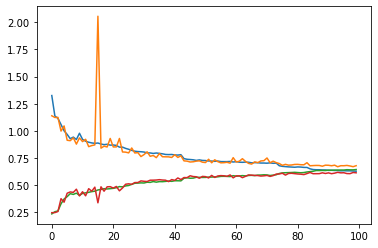

In [12]:
plt.plot(hist), best_acc

## Conventional pretrained VGG-16 

In [21]:
sample = models.vgg16_bn(pretrained=True)

# freeze feature extractor
for param in model.parameters():
    param.requires_grad = False
    
model.classifier[-1] = nn.Linear(4096, 7, bias=True)

# set trainble classifier
for param in model.classifier.parameters():
    param.requires_grad = True
    

In [22]:
device = torch.device('cuda')
print(device)

# model = Baseline()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [ ]:
model = model.to(device)

model_path = './vgg16_pretrained_classifier_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(20):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7646968364715576 Batch_id=448  Accuracy=25.40: 100%|██████████| 449/449 [00:33<00:00, 13.43it/s]

- Avg.loss: 1.850  | Avg.acc: 0.254


- Avg. val_loss: 1.868  | Avg. val_acc: 0.256


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.6368703842163086 Batch_id=448  Accuracy=26.49: 100%|██████████| 449/449 [00:32<00:00, 13.64it/s]

- Avg.loss: 1.815  | Avg.acc: 0.265


- Avg. val_loss: 1.816  | Avg. val_acc: 0.265


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.947483777999878 Batch_id=448  Accuracy=27.20: 100%|██████████| 449/449 [00:33<00:00, 13.42it/s] 

- Avg.loss: 1.803  | Avg.acc: 0.272


- Avg. val_loss: 1.760  | Avg. val_acc: 0.282


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.8129045963287354 Batch_id=448  Accuracy=26.98: 100%|██████████| 449/449 [00:36<00:00, 12.27it/s]

- Avg.loss: 1.798  | Avg.acc: 0.270



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.786  | Avg. val_acc: 0.276
Epoch:  5


Loss=1.9068448543548584 Batch_id=448  Accuracy=27.25: 100%|██████████| 449/449 [00:34<00:00, 13.15it/s]

- Avg.loss: 1.786  | Avg.acc: 0.273



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.806  | Avg. val_acc: 0.269
Epoch:  7


Loss=1.5308748483657837 Batch_id=448  Accuracy=27.25: 100%|██████████| 449/449 [00:33<00:00, 13.49it/s]

- Avg.loss: 1.776  | Avg.acc: 0.272


- Avg. val_loss: 1.736  | Avg. val_acc: 0.312


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.7620609998703003 Batch_id=448  Accuracy=27.50: 100%|██████████| 449/449 [00:34<00:00, 13.00it/s]

- Avg.loss: 1.778  | Avg.acc: 0.275



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.793  | Avg. val_acc: 0.259
Epoch:  9


Loss=1.7865666151046753 Batch_id=448  Accuracy=27.05: 100%|██████████| 449/449 [00:30<00:00, 14.93it/s]

- Avg.loss: 1.782  | Avg.acc: 0.270



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.774  | Avg. val_acc: 0.285
Epoch:  10


Loss=1.7486807107925415 Batch_id=448  Accuracy=27.41: 100%|██████████| 449/449 [00:32<00:00, 13.61it/s]

- Avg.loss: 1.781  | Avg.acc: 0.274



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.769  | Avg. val_acc: 0.299
Epoch:  11


Loss=1.7225258350372314 Batch_id=448  Accuracy=27.70: 100%|██████████| 449/449 [00:31<00:00, 14.24it/s]

- Avg.loss: 1.776  | Avg.acc: 0.277



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.780  | Avg. val_acc: 0.267
Epoch:  12


Loss=1.612300157546997 Batch_id=448  Accuracy=27.41: 100%|██████████| 449/449 [00:32<00:00, 13.76it/s] 

- Avg.loss: 1.779  | Avg.acc: 0.274



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.753  | Avg. val_acc: 0.282
Epoch:  13


Loss=1.79787015914917 Batch_id=448  Accuracy=27.00: 100%|██████████| 449/449 [00:30<00:00, 14.72it/s]  

- Avg.loss: 1.780  | Avg.acc: 0.270



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.778  | Avg. val_acc: 0.276
Epoch:  14


Loss=1.7023794651031494 Batch_id=448  Accuracy=27.14: 100%|██████████| 449/449 [00:33<00:00, 13.57it/s]

- Avg.loss: 1.777  | Avg.acc: 0.271



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.765  | Avg. val_acc: 0.269
Epoch:  15


Loss=1.784293532371521 Batch_id=448  Accuracy=26.75: 100%|██████████| 449/449 [00:33<00:00, 13.28it/s] 

- Avg.loss: 1.787  | Avg.acc: 0.268



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.756  | Avg. val_acc: 0.282
Epoch:  16


Loss=1.6990381479263306 Batch_id=448  Accuracy=28.64: 100%|██████████| 449/449 [00:33<00:00, 13.56it/s]

- Avg.loss: 1.761  | Avg.acc: 0.286



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.778  | Avg. val_acc: 0.302
Epoch:  18


Loss=1.7429569959640503 Batch_id=448  Accuracy=28.86: 100%|██████████| 449/449 [00:32<00:00, 13.64it/s]

- Avg.loss: 1.756  | Avg.acc: 0.289


- Avg. val_loss: 1.717  | Avg. val_acc: 0.315


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.8070627450942993 Batch_id=448  Accuracy=29.15: 100%|██████████| 449/449 [00:35<00:00, 12.75it/s]

- Avg.loss: 1.750  | Avg.acc: 0.292



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.762  | Avg. val_acc: 0.306
Epoch:  20


Loss=1.6549263000488281 Batch_id=244  Accuracy=29.67:  54%|█████▍    | 244/449 [00:16<00:13, 15.55it/s]

([<matplotlib.lines.Line2D at 0x7ff252c48320>,
 0.31707996656450266)

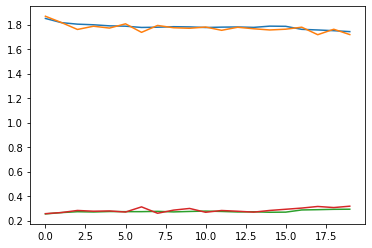

In [25]:
import pickle
pickle.dump(hist, open('./vgg16_pretrained_classifier_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [6]:
# fine tune

model = torch.load('vgg16_pretrained_classifier_model.pt')

for param in model.parameters():
    param.requires_grad = True
    


In [7]:
device = torch.device('cuda')
print(device)

# model = Baseline()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [8]:
model = model.to(device)

model_path = './vgg16_pretrained_finetune_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(50):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3080127239227295 Batch_id=448  Accuracy=43.10: 100%|██████████| 449/449 [00:47<00:00,  9.53it/s]

- Avg.loss: 1.478  | Avg.acc: 0.431


- Avg. val_loss: 1.249  | Avg. val_acc: 0.512


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.397241234779358 Batch_id=448  Accuracy=51.96: 100%|██████████| 449/449 [00:47<00:00,  9.48it/s] 

- Avg.loss: 1.266  | Avg.acc: 0.520


- Avg. val_loss: 1.150  | Avg. val_acc: 0.561


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.1128634214401245 Batch_id=448  Accuracy=56.15: 100%|██████████| 449/449 [00:47<00:00,  9.50it/s]

- Avg.loss: 1.174  | Avg.acc: 0.562


- Avg. val_loss: 1.116  | Avg. val_acc: 0.579


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.2032612562179565 Batch_id=448  Accuracy=58.51: 100%|██████████| 449/449 [00:47<00:00,  9.51it/s]

- Avg.loss: 1.108  | Avg.acc: 0.585


- Avg. val_loss: 1.058  | Avg. val_acc: 0.602


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.127485752105713 Batch_id=448  Accuracy=60.56: 100%|██████████| 449/449 [00:47<00:00,  9.48it/s] 

- Avg.loss: 1.063  | Avg.acc: 0.606


- Avg. val_loss: 1.033  | Avg. val_acc: 0.610


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.74354088306427 Batch_id=448  Accuracy=61.96: 100%|██████████| 449/449 [00:47<00:00,  9.48it/s]  

- Avg.loss: 1.021  | Avg.acc: 0.620


- Avg. val_loss: 1.000  | Avg. val_acc: 0.621


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.9222550392150879 Batch_id=448  Accuracy=63.48: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s]

- Avg.loss: 0.978  | Avg.acc: 0.635


- Avg. val_loss: 1.022  | Avg. val_acc: 0.631


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.8290072679519653 Batch_id=448  Accuracy=64.31: 100%|██████████| 449/449 [00:47<00:00,  9.50it/s]

- Avg.loss: 0.960  | Avg.acc: 0.643


- Avg. val_loss: 1.014  | Avg. val_acc: 0.634


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.070375919342041 Batch_id=448  Accuracy=65.88: 100%|██████████| 449/449 [00:47<00:00,  9.48it/s] 

- Avg.loss: 0.921  | Avg.acc: 0.659


- Avg. val_loss: 1.045  | Avg. val_acc: 0.635


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.8983892202377319 Batch_id=448  Accuracy=66.90: 100%|██████████| 449/449 [00:47<00:00,  9.49it/s]

- Avg.loss: 0.895  | Avg.acc: 0.669


- Avg. val_loss: 0.986  | Avg. val_acc: 0.643


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.8421728610992432 Batch_id=448  Accuracy=67.85: 100%|██████████| 449/449 [00:47<00:00,  9.48it/s]

- Avg.loss: 0.869  | Avg.acc: 0.678



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.003  | Avg. val_acc: 0.637
Epoch:  12


Loss=0.8357160687446594 Batch_id=448  Accuracy=69.10: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s]

- Avg.loss: 0.835  | Avg.acc: 0.691



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.043  | Avg. val_acc: 0.634
Epoch:  13


Loss=1.2124189138412476 Batch_id=448  Accuracy=69.83: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s] 

- Avg.loss: 0.814  | Avg.acc: 0.698


- Avg. val_loss: 1.034  | Avg. val_acc: 0.644


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.9269290566444397 Batch_id=448  Accuracy=71.36: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s] 

- Avg.loss: 0.780  | Avg.acc: 0.714


- Avg. val_loss: 0.999  | Avg. val_acc: 0.651


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=0.5986693501472473 Batch_id=448  Accuracy=72.30: 100%|██████████| 449/449 [00:47<00:00,  9.51it/s] 

- Avg.loss: 0.757  | Avg.acc: 0.723



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.996  | Avg. val_acc: 0.644
Epoch:  16


Loss=0.6905828714370728 Batch_id=448  Accuracy=72.68: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s] 

- Avg.loss: 0.740  | Avg.acc: 0.727


- Avg. val_loss: 1.016  | Avg. val_acc: 0.654


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=0.8199484348297119 Batch_id=448  Accuracy=73.77: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s] 

- Avg.loss: 0.716  | Avg.acc: 0.738



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.055  | Avg. val_acc: 0.647
Epoch:  18


Loss=0.6660003066062927 Batch_id=448  Accuracy=75.08: 100%|██████████| 449/449 [00:47<00:00,  9.45it/s] 

- Avg.loss: 0.689  | Avg.acc: 0.751



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.045  | Avg. val_acc: 0.647
Epoch:  19


Loss=0.7674283981323242 Batch_id=448  Accuracy=75.91: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s] 

- Avg.loss: 0.663  | Avg.acc: 0.759



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.115  | Avg. val_acc: 0.652
Epoch    19: reducing learning rate of group 0 to 5.0000e-05.
Epoch:  20


Loss=0.6656049489974976 Batch_id=448  Accuracy=78.92: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s] 

- Avg.loss: 0.575  | Avg.acc: 0.789


- Avg. val_loss: 1.086  | Avg. val_acc: 0.666


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.5841081738471985 Batch_id=448  Accuracy=80.77: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s] 

- Avg.loss: 0.535  | Avg.acc: 0.808



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.175  | Avg. val_acc: 0.653
Epoch:  22


Loss=0.35441815853118896 Batch_id=448  Accuracy=81.80: 100%|██████████| 449/449 [00:47<00:00,  9.49it/s]

- Avg.loss: 0.500  | Avg.acc: 0.818



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.163  | Avg. val_acc: 0.660
Epoch:  23


Loss=0.2604249119758606 Batch_id=448  Accuracy=82.70: 100%|██████████| 449/449 [00:47<00:00,  9.41it/s] 

- Avg.loss: 0.480  | Avg.acc: 0.827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.168  | Avg. val_acc: 0.660
Epoch:  24


Loss=0.35176733136177063 Batch_id=448  Accuracy=83.87: 100%|██████████| 449/449 [00:47<00:00,  9.44it/s]

- Avg.loss: 0.450  | Avg.acc: 0.839



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.186  | Avg. val_acc: 0.659
Epoch:  25


Loss=0.35163232684135437 Batch_id=448  Accuracy=84.36: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s]

- Avg.loss: 0.430  | Avg.acc: 0.844



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.235  | Avg. val_acc: 0.650
Epoch:  26


Loss=0.744689404964447 Batch_id=448  Accuracy=85.29: 100%|██████████| 449/449 [00:47<00:00,  9.45it/s]  

- Avg.loss: 0.410  | Avg.acc: 0.853



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.247  | Avg. val_acc: 0.658
Epoch:  27


Loss=0.3904382884502411 Batch_id=448  Accuracy=86.03: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s] 

- Avg.loss: 0.391  | Avg.acc: 0.860



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.305  | Avg. val_acc: 0.654
Epoch:  28


Loss=0.6033549904823303 Batch_id=448  Accuracy=86.61: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s] 

- Avg.loss: 0.375  | Avg.acc: 0.866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.310  | Avg. val_acc: 0.656
Epoch    28: reducing learning rate of group 0 to 2.5000e-05.
Epoch:  29


Loss=0.35677358508110046 Batch_id=448  Accuracy=89.07: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s]

- Avg.loss: 0.312  | Avg.acc: 0.891



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.450  | Avg. val_acc: 0.661
Epoch:  30


Loss=0.3947054445743561 Batch_id=448  Accuracy=89.59: 100%|██████████| 449/449 [00:47<00:00,  9.47it/s] 

- Avg.loss: 0.296  | Avg.acc: 0.896



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.468  | Avg. val_acc: 0.663
Epoch:  31


Loss=0.1723335236310959 Batch_id=448  Accuracy=89.83: 100%|██████████| 449/449 [00:47<00:00,  9.44it/s] 

- Avg.loss: 0.286  | Avg.acc: 0.898



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.495  | Avg. val_acc: 0.664
Epoch:  32


Loss=0.09587829560041428 Batch_id=448  Accuracy=90.64: 100%|██████████| 449/449 [00:47<00:00,  9.43it/s]

- Avg.loss: 0.268  | Avg.acc: 0.906



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.506  | Avg. val_acc: 0.654
Epoch:  33


Loss=0.18755383789539337 Batch_id=448  Accuracy=91.32: 100%|██████████| 449/449 [00:47<00:00,  9.43it/s]

- Avg.loss: 0.249  | Avg.acc: 0.913



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.542  | Avg. val_acc: 0.659
Epoch:  34


Loss=0.35968905687332153 Batch_id=448  Accuracy=91.33: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s]

- Avg.loss: 0.245  | Avg.acc: 0.913



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.564  | Avg. val_acc: 0.658
Epoch:  35


Loss=0.1745026558637619 Batch_id=448  Accuracy=91.48: 100%|██████████| 449/449 [00:47<00:00,  9.45it/s] 

- Avg.loss: 0.238  | Avg.acc: 0.915



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.598  | Avg. val_acc: 0.659
Epoch:  36


Loss=0.3120855391025543 Batch_id=448  Accuracy=92.17: 100%|██████████| 449/449 [00:47<00:00,  9.43it/s] 

- Avg.loss: 0.223  | Avg.acc: 0.922



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.673  | Avg. val_acc: 0.657
Epoch:  37


Loss=0.3009292781352997 Batch_id=448  Accuracy=92.47: 100%|██████████| 449/449 [00:47<00:00,  9.41it/s] 

- Avg.loss: 0.218  | Avg.acc: 0.925



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.669  | Avg. val_acc: 0.661
Epoch    37: reducing learning rate of group 0 to 1.2500e-05.
Epoch:  38


Loss=0.18842054903507233 Batch_id=448  Accuracy=93.26: 100%|██████████| 449/449 [00:47<00:00,  9.37it/s] 

- Avg.loss: 0.191  | Avg.acc: 0.933



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.735  | Avg. val_acc: 0.664
Epoch:  39


Loss=0.3214520514011383 Batch_id=448  Accuracy=93.90: 100%|██████████| 449/449 [00:48<00:00,  9.29it/s]  

- Avg.loss: 0.177  | Avg.acc: 0.939



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.761  | Avg. val_acc: 0.656
Epoch:  40


Loss=0.1366196572780609 Batch_id=448  Accuracy=94.17: 100%|██████████| 449/449 [00:47<00:00,  9.45it/s]  

- Avg.loss: 0.171  | Avg.acc: 0.942



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.763  | Avg. val_acc: 0.661
Epoch:  41


Loss=0.10322220623493195 Batch_id=448  Accuracy=94.21: 100%|██████████| 449/449 [00:47<00:00,  9.42it/s] 

- Avg.loss: 0.162  | Avg.acc: 0.942



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.829  | Avg. val_acc: 0.658
Epoch:  42


Loss=0.3094651699066162 Batch_id=448  Accuracy=94.29: 100%|██████████| 449/449 [00:47<00:00,  9.42it/s]  

- Avg.loss: 0.163  | Avg.acc: 0.943



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.824  | Avg. val_acc: 0.662
Epoch:  43


Loss=0.05352706462144852 Batch_id=448  Accuracy=94.63: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s] 

- Avg.loss: 0.158  | Avg.acc: 0.946



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.887  | Avg. val_acc: 0.662
Epoch:  44


Loss=0.14886948466300964 Batch_id=448  Accuracy=94.79: 100%|██████████| 449/449 [00:47<00:00,  9.43it/s] 

- Avg.loss: 0.148  | Avg.acc: 0.948



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.884  | Avg. val_acc: 0.664
Epoch:  45


Loss=0.18238818645477295 Batch_id=448  Accuracy=95.02: 100%|██████████| 449/449 [00:47<00:00,  9.45it/s] 

- Avg.loss: 0.144  | Avg.acc: 0.950



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.947  | Avg. val_acc: 0.659
Epoch:  46


Loss=0.09373258799314499 Batch_id=448  Accuracy=95.17: 100%|██████████| 449/449 [00:47<00:00,  9.45it/s] 

- Avg.loss: 0.138  | Avg.acc: 0.952



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.943  | Avg. val_acc: 0.662
Epoch    46: reducing learning rate of group 0 to 6.2500e-06.
Epoch:  47


Loss=0.11057712137699127 Batch_id=448  Accuracy=95.29: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s] 

- Avg.loss: 0.135  | Avg.acc: 0.953



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.976  | Avg. val_acc: 0.661
Epoch:  48


Loss=0.14984485507011414 Batch_id=448  Accuracy=95.61: 100%|██████████| 449/449 [00:47<00:00,  9.44it/s] 

- Avg.loss: 0.126  | Avg.acc: 0.956



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.967  | Avg. val_acc: 0.661
Epoch:  49


Loss=0.03547689691185951 Batch_id=448  Accuracy=95.94: 100%|██████████| 449/449 [00:47<00:00,  9.46it/s] 

- Avg.loss: 0.115  | Avg.acc: 0.959


- Avg. val_loss: 2.063  | Avg. val_acc: 0.667


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  50


Loss=0.0338355153799057 Batch_id=448  Accuracy=95.81: 100%|██████████| 449/449 [00:47<00:00,  9.49it/s]  

- Avg.loss: 0.118  | Avg.acc: 0.958


- Avg. val_loss: 2.072  | Avg. val_acc: 0.666
Finished Training


([<matplotlib.lines.Line2D at 0x7feb81dfc668>,
 0.6673168013374199)

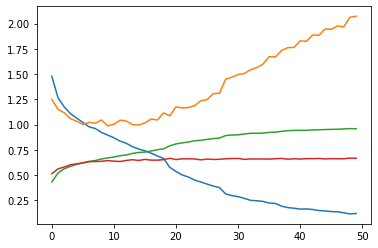

In [9]:
import pickle
pickle.dump(hist, open('./vgg16_pretrained_finetune_hist.hdf5', 'wb'))

plt.plot(hist), best_acc

In [11]:
model = torch.load('./vgg16_pretrained_finetune_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))


- Avg. val_loss: 1.916  | Avg. val_acc: 0.682


## Transfer learning optimization

### Resnet-18 w.o triplet loss

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))
8 w.o triplet 
        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
#         src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, extractor_grad=True, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        resnet = models.resnet18(pretrained=True)
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        self.avgpool = resnet.avgpool
        
        for param in self.parameters():
            param.requires_grad = False
        
        self.fact0_1 = FeatureAct(64, 128)
        self.fact1_2 = FeatureAct(128, 256)
        self.fact2_3 = FeatureAct(256, 512)
        
#         self.fc = nn.Linear(512, 7, bias=True)
        
        self.fc = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                nn.Linear(128, 7), nn.BatchNorm1d(7))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x0 = self.layer1(x)
        
        x1 = self.layer2(x0)
        xfact0_1 = self.fact0_1(x0, x1)
        
        x2 = self.layer3(xfact0_1)
        xfact1_2 = self.fact1_2(x1, x2)
        
        x3 = self.layer4(xfact1_2)
        xfact2_3 = self.fact2_3(x2, x3)
        
        
        x_emb = self.avgpool(xfact2_3)
        x_emb = nn.Flatten()(x_emb)
        
        x_out = self.fc(x_emb)
        
        return x_out

In [8]:
device = torch.device('cuda')
print(device)

model = BaselineFeatureAct().to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [9]:
model = model.to(device)

model_path = './feature_act_resnet18pretrained_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(30):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.838853120803833 Batch_id=224  Accuracy=29.90: 100%|██████████| 225/225 [00:33<00:00,  6.69it/s] 

- Avg.loss: 1.791  | Avg.acc: 0.299



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.748  | Avg. val_acc: 0.304
* Update optimal model
Epoch:  2


Loss=1.508199691772461 Batch_id=224  Accuracy=31.35: 100%|██████████| 225/225 [00:33<00:00,  6.74it/s] 

- Avg.loss: 1.719  | Avg.acc: 0.314


- Avg. val_loss: 1.711  | Avg. val_acc: 0.316


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.7440241575241089 Batch_id=224  Accuracy=32.29: 100%|██████████| 225/225 [00:34<00:00,  6.53it/s]

- Avg.loss: 1.698  | Avg.acc: 0.323


- Avg. val_loss: 1.697  | Avg. val_acc: 0.321


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.6933647394180298 Batch_id=224  Accuracy=32.40: 100%|██████████| 225/225 [00:33<00:00,  6.67it/s]

- Avg.loss: 1.690  | Avg.acc: 0.324



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.703  | Avg. val_acc: 0.313
Epoch:  5


Loss=1.7913659811019897 Batch_id=224  Accuracy=32.58: 100%|██████████| 225/225 [00:33<00:00,  6.75it/s]

- Avg.loss: 1.687  | Avg.acc: 0.326



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.697  | Avg. val_acc: 0.317
Epoch:  6


Loss=1.7761787176132202 Batch_id=224  Accuracy=32.68: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]

- Avg.loss: 1.685  | Avg.acc: 0.327



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.711  | Avg. val_acc: 0.312
Epoch:  7


Loss=1.8228553533554077 Batch_id=224  Accuracy=32.48: 100%|██████████| 225/225 [00:33<00:00,  6.78it/s]

- Avg.loss: 1.685  | Avg.acc: 0.325


- Avg. val_loss: 1.681  | Avg. val_acc: 0.327


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.7941744327545166 Batch_id=224  Accuracy=32.78: 100%|██████████| 225/225 [00:33<00:00,  6.71it/s]

- Avg.loss: 1.681  | Avg.acc: 0.328


- Avg. val_loss: 1.688  | Avg. val_acc: 0.328


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.5207065343856812 Batch_id=224  Accuracy=32.29: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.682  | Avg.acc: 0.323



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.704  | Avg. val_acc: 0.325
Epoch:  10


Loss=1.6497467756271362 Batch_id=224  Accuracy=32.72: 100%|██████████| 225/225 [00:33<00:00,  6.78it/s]

- Avg.loss: 1.682  | Avg.acc: 0.327



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.683  | Avg. val_acc: 0.327
Epoch:  11


Loss=1.615468978881836 Batch_id=224  Accuracy=32.85: 100%|██████████| 225/225 [00:33<00:00,  6.77it/s] 

- Avg.loss: 1.678  | Avg.acc: 0.328



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.708  | Avg. val_acc: 0.308
Epoch:  12


Loss=1.6666573286056519 Batch_id=224  Accuracy=32.86: 100%|██████████| 225/225 [00:33<00:00,  6.70it/s]

- Avg.loss: 1.678  | Avg.acc: 0.329



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.693  | Avg. val_acc: 0.321
Epoch:  13


Loss=1.589877963066101 Batch_id=224  Accuracy=33.02: 100%|██████████| 225/225 [00:33<00:00,  6.76it/s] 

- Avg.loss: 1.675  | Avg.acc: 0.330



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.699  | Avg. val_acc: 0.320
Epoch:  14


Loss=1.6214486360549927 Batch_id=224  Accuracy=33.03: 100%|██████████| 225/225 [00:33<00:00,  6.76it/s]

- Avg.loss: 1.676  | Avg.acc: 0.330


- Avg. val_loss: 1.683  | Avg. val_acc: 0.333


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=1.9222047328948975 Batch_id=224  Accuracy=33.37: 100%|██████████| 225/225 [00:33<00:00,  6.71it/s]

- Avg.loss: 1.676  | Avg.acc: 0.334



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.694  | Avg. val_acc: 0.324
Epoch:  16


Loss=1.773193120956421 Batch_id=224  Accuracy=33.06: 100%|██████████| 225/225 [00:33<00:00,  6.79it/s] 

- Avg.loss: 1.679  | Avg.acc: 0.331



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.684  | Avg. val_acc: 0.326
Epoch    16: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  17


Loss=1.5692112445831299 Batch_id=224  Accuracy=33.98: 100%|██████████| 225/225 [00:32<00:00,  6.82it/s]

- Avg.loss: 1.661  | Avg.acc: 0.340


- Avg. val_loss: 1.674  | Avg. val_acc: 0.337


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.616842269897461 Batch_id=224  Accuracy=33.92: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s] 

- Avg.loss: 1.661  | Avg.acc: 0.339



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.664  | Avg. val_acc: 0.333
Epoch:  19


Loss=1.637075662612915 Batch_id=224  Accuracy=33.74: 100%|██████████| 225/225 [00:33<00:00,  6.75it/s] 

- Avg.loss: 1.660  | Avg.acc: 0.337


- Avg. val_loss: 1.663  | Avg. val_acc: 0.342


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=1.9365360736846924 Batch_id=224  Accuracy=33.79: 100%|██████████| 225/225 [00:33<00:00,  6.69it/s]

- Avg.loss: 1.664  | Avg.acc: 0.338



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.671  | Avg. val_acc: 0.342
Epoch:  21


Loss=1.7702999114990234 Batch_id=224  Accuracy=33.93: 100%|██████████| 225/225 [00:32<00:00,  6.84it/s]

- Avg.loss: 1.656  | Avg.acc: 0.339



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.666  | Avg. val_acc: 0.334
Epoch:  22


Loss=1.7697222232818604 Batch_id=224  Accuracy=33.72: 100%|██████████| 225/225 [00:33<00:00,  6.74it/s]


- Avg.loss: 1.660  | Avg.acc: 0.337


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.678  | Avg. val_acc: 0.326
Epoch:  23


Loss=1.6980010271072388 Batch_id=224  Accuracy=33.73: 100%|██████████| 225/225 [00:33<00:00,  6.81it/s]

- Avg.loss: 1.655  | Avg.acc: 0.337



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.672  | Avg. val_acc: 0.333
Epoch:  24


Loss=1.820604681968689 Batch_id=224  Accuracy=34.29: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s] 

- Avg.loss: 1.656  | Avg.acc: 0.343


- Avg. val_loss: 1.662  | Avg. val_acc: 0.343


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=1.6005816459655762 Batch_id=224  Accuracy=34.32: 100%|██████████| 225/225 [00:33<00:00,  6.66it/s]

- Avg.loss: 1.654  | Avg.acc: 0.343



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.680  | Avg. val_acc: 0.330
Epoch:  26


Loss=1.7416505813598633 Batch_id=224  Accuracy=34.41: 100%|██████████| 225/225 [00:33<00:00,  6.65it/s]

- Avg.loss: 1.650  | Avg.acc: 0.344



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.669  | Avg. val_acc: 0.333
Epoch:  27


Loss=1.801274061203003 Batch_id=224  Accuracy=34.22: 100%|██████████| 225/225 [00:33<00:00,  6.68it/s] 

- Avg.loss: 1.656  | Avg.acc: 0.342



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.685  | Avg. val_acc: 0.329
Epoch:  28


Loss=1.6079607009887695 Batch_id=224  Accuracy=33.74: 100%|██████████| 225/225 [00:33<00:00,  6.70it/s]

- Avg.loss: 1.655  | Avg.acc: 0.337



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.675  | Avg. val_acc: 0.327
Epoch:  29


Loss=1.703206181526184 Batch_id=224  Accuracy=34.40: 100%|██████████| 225/225 [00:33<00:00,  6.64it/s] 

- Avg.loss: 1.654  | Avg.acc: 0.344



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.673  | Avg. val_acc: 0.326
Epoch:  30


Loss=1.7932279109954834 Batch_id=224  Accuracy=33.94: 100%|██████████| 225/225 [00:33<00:00,  6.82it/s]

- Avg.loss: 1.655  | Avg.acc: 0.339


- Avg. val_loss: 1.663  | Avg. val_acc: 0.340
Finished Training


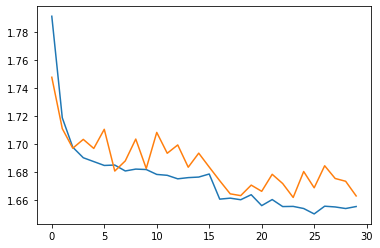

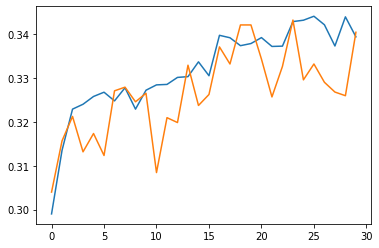

0.3432711061577041

In [13]:
import pickle
pickle.dump(hist, open('feature_act_resnet18pretrained_hist.hdf5', 'wb'))


plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()

plt.plot([k[2] for k in hist])
plt.plot([k[3] for k in hist])
plt.show()

best_acc

In [14]:
model = torch.load('feature_act_resnet18pretrained_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.665  | Avg. val_acc: 0.331


In [15]:
# fine tune
model = torch.load('feature_act_resnet18pretrained_model.pt')
for param in model.parameters():
    param.requires_grad = True

In [16]:
device = torch.device('cuda')
print(device)

# model = BaselineFeatureAct().to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [ ]:
model = model.to(device)

model_path = './feature_act_resnet18_finetune_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(50):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4723807573318481 Batch_id=224  Accuracy=45.61: 100%|██████████| 225/225 [05:04<00:00,  1.35s/it]

- Avg.loss: 1.446  | Avg.acc: 0.456



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.355  | Avg. val_acc: 0.507
* Update optimal model
Epoch:  2


Loss=1.4133280515670776 Batch_id=224  Accuracy=51.97: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.320  | Avg.acc: 0.520


- Avg. val_loss: 1.262  | Avg. val_acc: 0.551


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.2183750867843628 Batch_id=224  Accuracy=54.11: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.258  | Avg.acc: 0.541


- Avg. val_loss: 1.225  | Avg. val_acc: 0.559


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.347650408744812 Batch_id=224  Accuracy=55.84: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it] 

- Avg.loss: 1.212  | Avg.acc: 0.558


- Avg. val_loss: 1.184  | Avg. val_acc: 0.575


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.3499717712402344 Batch_id=224  Accuracy=56.76: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.184  | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.168  | Avg. val_acc: 0.573
Epoch:  6


Loss=1.1191867589950562 Batch_id=224  Accuracy=57.65: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.148  | Avg.acc: 0.577


- Avg. val_loss: 1.152  | Avg. val_acc: 0.578


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.2218440771102905 Batch_id=224  Accuracy=59.10: 100%|██████████| 225/225 [05:04<00:00,  1.35s/it]

- Avg.loss: 1.125  | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161  | Avg. val_acc: 0.572
Epoch:  8


Loss=1.1668367385864258 Batch_id=224  Accuracy=59.59: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.101  | Avg.acc: 0.596


- Avg. val_loss: 1.121  | Avg. val_acc: 0.593


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.1040973663330078 Batch_id=224  Accuracy=60.14: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.083  | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121  | Avg. val_acc: 0.582
Epoch:  10


Loss=0.8861970901489258 Batch_id=224  Accuracy=60.75: 100%|██████████| 225/225 [05:04<00:00,  1.36s/it]

- Avg.loss: 1.069  | Avg.acc: 0.608


- Avg. val_loss: 1.081  | Avg. val_acc: 0.601


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.2542097568511963 Batch_id=224  Accuracy=61.31: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.047  | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116  | Avg. val_acc: 0.583
Epoch:  12


Loss=1.3286091089248657 Batch_id=224  Accuracy=62.04: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.032  | Avg.acc: 0.620


- Avg. val_loss: 1.086  | Avg. val_acc: 0.604


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=0.845731258392334 Batch_id=224  Accuracy=62.58: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it] 

- Avg.loss: 1.018  | Avg.acc: 0.626


- Avg. val_loss: 1.075  | Avg. val_acc: 0.606


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.3070878982543945 Batch_id=224  Accuracy=63.17: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 1.001  | Avg.acc: 0.632


- Avg. val_loss: 1.080  | Avg. val_acc: 0.612


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=1.267879605293274 Batch_id=224  Accuracy=63.50: 100%|██████████| 225/225 [05:04<00:00,  1.36s/it] 

- Avg.loss: 0.987  | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056  | Avg. val_acc: 0.610
Epoch:  16


Loss=1.1077347993850708 Batch_id=224  Accuracy=64.27: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 0.976  | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066  | Avg. val_acc: 0.601
Epoch:  17


Loss=0.9384129643440247 Batch_id=180  Accuracy=64.54:  80%|████████  | 180/225 [04:06<01:00,  1.35s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9905836582183838 Batch_id=224  Accuracy=75.59: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 0.684  | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067  | Avg. val_acc: 0.632
Epoch:  36


Loss=0.8764944076538086 Batch_id=224  Accuracy=76.83: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it] 

- Avg.loss: 0.657  | Avg.acc: 0.768


- Avg. val_loss: 1.051  | Avg. val_acc: 0.641


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=0.41930413246154785 Batch_id=224  Accuracy=77.73: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it]

- Avg.loss: 0.635  | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076  | Avg. val_acc: 0.640
Epoch:  38


Loss=0.8037413954734802 Batch_id=224  Accuracy=78.45: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it] 

- Avg.loss: 0.609  | Avg.acc: 0.784


- Avg. val_loss: 1.063  | Avg. val_acc: 0.642


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=0.3989802598953247 Batch_id=224  Accuracy=79.08: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it] 

- Avg.loss: 0.597  | Avg.acc: 0.791



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099  | Avg. val_acc: 0.633
Epoch:  40


Loss=0.5026747584342957 Batch_id=224  Accuracy=79.48: 100%|██████████| 225/225 [05:05<00:00,  1.36s/it] 

- Avg.loss: 0.584  | Avg.acc: 0.795



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117  | Avg. val_acc: 0.636
Epoch:  41


Loss=0.47471386194229126 Batch_id=79  Accuracy=80.85:  35%|███▌      | 79/225 [01:50<03:17,  1.35s/it]

([<matplotlib.lines.Line2D at 0x7f3079a1ff28>,
 0.6439119531903037)

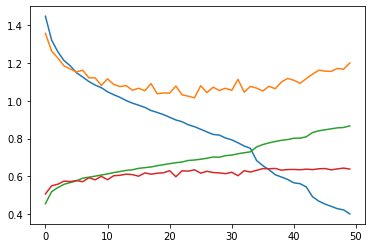

In [20]:
import pickle
pickle.dump(hist, open('./feature_act_resnet18_finetune_hist.hdf5','wb'))

plt.plot(hist), best_acc

In [21]:
model = torch.load('feature_act_resnet18_finetune_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.166  | Avg. val_acc: 0.639


### Resnet-18 with Feature Act.

In [ ]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [9]:
resnet = models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.src_conv = nn.Sequential(nn.Conv2d(src_feature, src_feature, kernel_size=(3,3), stride=1, padding=1),
                                      nn.BatchNorm2d(src_feature), nn.ReLU(inplace=True))

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        
#         src_feature = self.src_conv(src_x)
        
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)

        target_x = target_x * (1 + cor_feature)

        return target_x

In [9]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, extractor_grad=True, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        resnet = models.resnet18(pretrained=True)
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        self.avgpool = resnet.avgpool
        
        for param in self.parameters():
            param.requires_grad = False
        
        self.fact0_1 = FeatureAct(64, 128)
        self.fact1_2 = FeatureAct(128, 256)
        self.fact2_3 = FeatureAct(256, 512)
        
#         self.fc = nn.Linear(512, 7, bias=True)
        
        self.fc = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                nn.Linear(128, 7), nn.BatchNorm1d(7))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x0 = self.layer1(x)
        
        x1 = self.layer2(x0)
        xfact0_1 = self.fact0_1(x0, x1)
        
        x2 = self.layer3(xfact0_1)
        xfact1_2 = self.fact1_2(x1, x2)
        
        x3 = self.layer4(xfact1_2)
        xfact2_3 = self.fact2_3(x2, x3)
        
        
        x_emb = self.avgpool(xfact2_3)
        x_emb = nn.Flatten()(x_emb)
        
        x_out = self.fc(x_emb)
        
        return x_out, x_emb

In [10]:
device = torch.device('cuda')
model = BaselineFeatureAct(extractor_grad=False).to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=True)


distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [11]:
model_path = './feature_act_resnet18pretrained_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
        
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.0939030647277832 cep_loss=1.728912115097046 triplet_loss=0.1413893848657608 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [03:10<00:00,  2.36it/s]

- Avg.loss: 1.124 | Avg.acc: 0.294


- Avg. val_loss: 1.088 | Avg. val_acc: 0.310


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.043716549873352 cep_loss=1.6433606147766113 triplet_loss=0.14425036311149597 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [03:15<00:00,  2.29it/s]

- Avg.loss: 1.082 | Avg.acc: 0.312


- Avg. val_loss: 1.084 | Avg. val_acc: 0.312


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.09293794631958 cep_loss=1.7212618589401245 triplet_loss=0.15045185387134552 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [03:08<00:00,  2.38it/s]

- Avg.loss: 1.075 | Avg.acc: 0.317


- Avg. val_loss: 1.079 | Avg. val_acc: 0.314


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.10294771194458 cep_loss=1.7397809028625488 triplet_loss=0.14769788086414337 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [03:16<00:00,  2.29it/s]

- Avg.loss: 1.075 | Avg.acc: 0.319



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.094 | Avg. val_acc: 0.307
Epoch:  5


Loss=0.9922390580177307 cep_loss=1.5588977336883545 triplet_loss=0.14225098490715027 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [03:14<00:00,  2.30it/s]

- Avg.loss: 1.076 | Avg.acc: 0.323


- Avg. val_loss: 1.080 | Avg. val_acc: 0.323


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.0558899641036987 cep_loss=1.6651625633239746 triplet_loss=0.1419808268547058 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [03:11<00:00,  2.35it/s]

- Avg.loss: 1.076 | Avg.acc: 0.318



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.082 | Avg. val_acc: 0.313
Epoch:  7


Loss=1.0523626804351807 cep_loss=1.6562654972076416 triplet_loss=0.14650829136371613 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [03:16<00:00,  2.29it/s]

- Avg.loss: 1.076 | Avg.acc: 0.316



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.304
Epoch:  8


Loss=1.0998921394348145 cep_loss=1.7390671968460083 triplet_loss=0.14112964272499084 Batch_id=227 Accuracy=0.203125:  51%|█████     | 228/449 [01:28<01:25,  2.58it/s]


RuntimeError: DataLoader worker (pid 30519) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

In [ ]:
model_path = './feature_act_resnet50pretrained_tripletloss_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        all_loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (all_loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={all_loss.item()} cep_loss={loss.item()} triplet_loss={triplet_loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        triplet_loss = loss_func(embeddings, labels, indices_tuple)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        all_loss = (0.6*loss) + (0.4*triplet_loss)
        
        running_valloss += (all_loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
        
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=0.9968816637992859 cep_loss=1.5924831628799438 triplet_loss=0.10347935557365417 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [4:06:07<00:00, 32.89s/it]

- Avg.loss: 1.162 | Avg.acc: 0.272


- Avg. val_loss: 1.036 | Avg. val_acc: 0.317


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=0.969752311706543 cep_loss=1.5456501245498657 triplet_loss=0.10590554773807526 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [4:06:11<00:00, 32.90s/it]

- Avg.loss: 0.975 | Avg.acc: 0.391


- Avg. val_loss: 0.939 | Avg. val_acc: 0.408


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.8540058135986328 cep_loss=1.3508838415145874 triplet_loss=0.10868857055902481 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [4:06:06<00:00, 32.89s/it]

- Avg.loss: 0.923 | Avg.acc: 0.430



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.943 | Avg. val_acc: 0.403
Epoch:  4


Loss=0.7907946109771729 cep_loss=1.2516330480575562 triplet_loss=0.09953686594963074 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [4:06:05<00:00, 32.88s/it]

- Avg.loss: 0.902 | Avg.acc: 0.444


- Avg. val_loss: 0.908 | Avg. val_acc: 0.451


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.9847667217254639 cep_loss=1.5684559345245361 triplet_loss=0.10923276841640472 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [4:06:06<00:00, 32.89s/it]

- Avg.loss: 0.891 | Avg.acc: 0.452



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.931 | Avg. val_acc: 0.430
Epoch:  6


Loss=0.8758241534233093 cep_loss=1.3908909559249878 triplet_loss=0.10322388261556625 Batch_id=407 Accuracy=0.421875:  91%|█████████ | 408/449 [3:43:52<22:30, 32.93s/it]  